# Build a Baseline Model

Here I build a baseline model for comparison with model building in the future.

### Load Modules

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima import auto_arima
%matplotlib inline

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
!ls 1.collect_data/

1.1_Get_All_Parking_Zones.ipynb       README.md
1.2_Get_Detailed_Blockface_Info.ipynb Test_Collecting_Data.ipynb
1.3_Get_Parking_Data.ipynb            Untitled.ipynb
1.4_Format_archived_data.ipynb        block_locations.csv
1.5_Process_Weather_Data.ipynb        blockface_detail.csv
2019.1001.pkl                         data_by_day.pkl
2019.1002.pkl                         data_files
2019.1006.pkl                         failed
GetParkingData.py                     seattle_map.png


In [4]:
blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')

In [5]:
blockface_detail_locs = blockface_detail[['latitude', 'longitude', 'sourceelementkey']]
blockface_detail_locs.head()

,latitude,longitude,sourceelementkey
0,47.602873,-122.334694,1001
1,47.602949,-122.334513,1002
2,47.603674,-122.335143,1006
3,47.605018,-122.336658,1009
4,47.605101,-122.336447,1010


Load in dataframe 

In [6]:
df = pd.read_pickle('1.collect_data/data_files/15min.pkl').dropna()

In [7]:
df.head()

PaidOccupancy  ParkingSpaceCount  \
SourceElementKey OccupancyDateTime                                       
1001             2012-01-03 09:00:00       0.133333                7.0   
                 2012-01-03 09:15:00       1.000000                7.0   
                 2012-01-03 09:30:00       1.000000                7.0   
                 2012-01-03 09:45:00       1.800000                7.0   
                 2012-01-03 10:00:00       1.933333                7.0   

                                      PercentOccupied  
SourceElementKey OccupancyDateTime                     
1001             2012-01-03 09:00:00         0.019048  
                 2012-01-03 09:15:00         0.142857  
                 2012-01-03 09:30:00         0.142857  
                 2012-01-03 09:45:00         0.257143  
                 2012-01-03 10:00:00         0.276190

Reset index required to use the blockID and datetime as parameters for the model

In [8]:
df.reset_index(inplace=True)

In [9]:
last_two_years = df[df['OccupancyDateTime'] > '2018-01-01 00:00:00']

In [10]:
last_two_years.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
67211,1001,2018-01-02 09:00:00,0.0,5.0,0.0
67212,1001,2018-01-02 09:15:00,0.0,5.0,0.0
67213,1001,2018-01-02 09:30:00,0.0,5.0,0.0
67214,1001,2018-01-02 09:45:00,0.0,5.0,0.0
67215,1001,2018-01-02 10:00:00,0.0,5.0,0.0


In [11]:
last_two_years.tail().OccupancyDateTime.dt.dayofweek

144176748    4
144176749    4
144176750    4
144176751    4
144176752    4
Name: OccupancyDateTime, dtype: int64

In [12]:
merged = pd.merge(last_two_years, 
                  blockface_detail_locs, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop('sourceelementkey', axis=1)

In [13]:
merged.tail()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied,latitude,longitude
32360200,121340,2019-08-30 16:00:00,0.0,2.0,0.0,47.624221,-122.333423
32360201,121340,2019-08-30 16:15:00,0.0,2.0,0.0,47.624221,-122.333423
32360202,121340,2019-08-30 16:30:00,0.0,2.0,0.0,47.624221,-122.333423
32360203,121340,2019-08-30 16:45:00,0.0,2.0,0.0,47.624221,-122.333423
32360204,121340,2019-08-30 17:00:00,0.0,2.0,0.0,47.624221,-122.333423


Here I add month,day, year etc. so that the ML model can be trained on them.

In [14]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day

In [15]:
merged['Dummy'] = 0

In [16]:
merged.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,Dummy
0,1001,2018-01-02 09:00:00,0.0,5.0,0.0,47.602873,-122.334694,1,2018,9,1,2,0
1,1001,2018-01-02 09:15:00,0.0,5.0,0.0,47.602873,-122.334694,1,2018,9,1,2,0
2,1001,2018-01-02 09:30:00,0.0,5.0,0.0,47.602873,-122.334694,1,2018,9,1,2,0
3,1001,2018-01-02 09:45:00,0.0,5.0,0.0,47.602873,-122.334694,1,2018,9,1,2,0
4,1001,2018-01-02 10:00:00,0.0,5.0,0.0,47.602873,-122.334694,1,2018,10,1,2,0


In [17]:
# y = df['PercentOccupied'].values
# X = df[['Dummy', 'SourceElementKey']]

Split the data into train and test sets

In [18]:
df_train, df_test = train_test_split(
    merged, test_size=0.3, random_state=42)

In [19]:
baseline_columns = ['Dummy', 'SourceElementKey']

Build the actual dataset objects for LightGBM

In [20]:
lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                        label=df_train['PercentOccupied'], 
                        feature_name=baseline_columns, 
                        categorical_feature=['SourceElementKey'])
lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                       label=df_test['PercentOccupied'], 
                       feature_name=baseline_columns, 
                       categorical_feature=['SourceElementKey'],
                       reference=lgb_train)

Set the parameters for the ML model

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

Train model only on dummy variable and blockID

In [22]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
               valid_sets=lgb_test)

print('Saving model...')
# save model to file
gbm.save_model('baseline_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l2: 0.142787	valid_0's l1: 0.289265
[2]	valid_0's l2: 0.138308	valid_0's l1: 0.284308
[3]	valid_0's l2: 0.134264	valid_0's l1: 0.279692
[4]	valid_0's l2: 0.130609	valid_0's l1: 0.275393
[5]	valid_0's l2: 0.127302	valid_0's l1: 0.271416
[6]	valid_0's l2: 0.124312	valid_0's l1: 0.267728
[7]	valid_0's l2: 0.121605	valid_0's l1: 0.264334
[8]	valid_0's l2: 0.119161	valid_0's l1: 0.261179
[9]	valid_0's l2: 0.116945	valid_0's l1: 0.258218
[10]	valid_0's l2: 0.114938	valid_0's l1: 0.255464
[11]	valid_0's l2: 0.113119	valid_0's l1: 0.252891
[12]	valid_0's l2: 0.111474	valid_0's l1: 0.250501
[13]	valid_0's l2: 0.109975	valid_0's l1: 0.24829
[14]	valid_0's l2: 0.108622	valid_0's l1: 0.24621
[15]	valid_0's l2: 0.107388	valid_0's l1: 0.244268
[16]	valid_0's l2: 0.106278	valid_0's l1: 0.242509
[17]	valid_0's l2: 0.105269	valid_0's l1: 0.24086
[18]	valid_0's l2: 0.104346	valid_0's l1: 0.239291
[19]	valid_0's l2: 0.103511	valid_0's l1: 0.237834
[20]	valid_0's l2: 0.102756	valid_0's l1: 0

In [23]:
y_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)

In [24]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [25]:
baseline_smape = smape_error(y_pred, df_test['PercentOccupied'])
print('smape: %f' % baseline_smape)

smape: 33.583995


# Simple Model

Build a simple model only on datetime info and blockID

In [26]:
df.tail().OccupancyDateTime.dt.day

144176748    30
144176749    30
144176750    30
144176751    30
144176752    30
Name: OccupancyDateTime, dtype: int64

In [27]:
simple_columns = ['SourceElementKey', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'latitude', 'longitude']

In [28]:
simple_train = lgb.Dataset(data=df_train[simple_columns], 
                           label=df_train['PercentOccupied'],
                            feature_name=simple_columns, 
                       categorical_feature=['SourceElementKey', 'DayOfWeek'])
simple_test = lgb.Dataset(data=df_test[simple_columns], 
                          label=df_test['PercentOccupied'], 
                          feature_name=simple_columns, 
                          categorical_feature=['SourceElementKey', 'DayOfWeek'],
                          reference=simple_train)

In [29]:
print('Starting training...')
# train
gbm_simple = lgb.train(params,
                simple_train,
                valid_sets=simple_test)

print('Saving model...')
# save model to file
gbm_simple.save_model('simple_ml_model.txt')

Starting training...
[1]	valid_0's l2: 0.142441	valid_0's l1: 0.288976
[2]	valid_0's l2: 0.137636	valid_0's l1: 0.283674
[3]	valid_0's l2: 0.135221	valid_0's l1: 0.280627
[4]	valid_0's l2: 0.131283	valid_0's l1: 0.27609
[5]	valid_0's l2: 0.129213	valid_0's l1: 0.273458
[6]	valid_0's l2: 0.125574	valid_0's l1: 0.269226
[7]	valid_0's l2: 0.122283	valid_0's l1: 0.265306
[8]	valid_0's l2: 0.119294	valid_0's l1: 0.261622
[9]	valid_0's l2: 0.116548	valid_0's l1: 0.258182
[10]	valid_0's l2: 0.114051	valid_0's l1: 0.254978
[11]	valid_0's l2: 0.111745	valid_0's l1: 0.252011
[12]	valid_0's l2: 0.109671	valid_0's l1: 0.249217
[13]	valid_0's l2: 0.108618	valid_0's l1: 0.247695
[14]	valid_0's l2: 0.107669	valid_0's l1: 0.246296
[15]	valid_0's l2: 0.105894	valid_0's l1: 0.243732
[16]	valid_0's l2: 0.105058	valid_0's l1: 0.242458
[17]	valid_0's l2: 0.103486	valid_0's l1: 0.24025
[18]	valid_0's l2: 0.101985	valid_0's l1: 0.238197
[19]	valid_0's l2: 0.100493	valid_0's l1: 0.235997
[20]	valid_0's l2: 0.

In [30]:
y_pred = gbm_simple.predict(df_test[simple_columns], num_iteration=gbm_simple.best_iteration)

In [31]:
simple_smape = smape_error(y_pred, df_test['PercentOccupied'])
print('smape: %f' % simple_smape)

smape: 32.201023


This only slightly improves the model compared to the baseline

# Baseline Timeseries
Predict model based on previous values

First, predict values based on value 15 minutes ago

In [32]:
# shift values by one
pred_values = pd.concat([pd.Series([0]), df['PercentOccupied']])
timeseries_smape = smape_error(pred_values.values[:-1], df['PercentOccupied'])
print('smape: %f' % timeseries_smape)

smape: 12.955439


Next, predict value based on value 1 hour ago

In [33]:
# shift values by four (i.e. 1 hour)
pred_values = pd.concat([pd.Series([0,0,0,0]), df['PaidOccupancy']])
timeseries_smape = smape_error(pred_values.values[:-4], df['PaidOccupancy'])
print('smape: %f' % timeseries_smape)

smape: 28.535425


## SARIMA

In [66]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.133333,7.0,0.019048
1,1001,2012-01-03 09:15:00,1.000000,7.0,0.142857
2,1001,2012-01-03 09:30:00,1.000000,7.0,0.142857
3,1001,2012-01-03 09:45:00,1.800000,7.0,0.257143
4,1001,2012-01-03 10:00:00,1.933333,7.0,0.276190


In [113]:
blockface_detail.sourceelementkey.values

array([  1001,   1002,   1006, ..., 135261, 136041, 136322])

In [114]:
block = 1006
mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > ('2019-01-01'))

curr = df[mask]
pct_occupied = curr.PercentOccupied

In [115]:
curr.tail(38)

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
357711,1006,2019-08-31 09:45:00,1.000000,7.0,0.142857
357712,1006,2019-08-31 10:00:00,0.133333,7.0,0.019048
357713,1006,2019-08-31 10:15:00,1.000000,7.0,0.142857
357714,1006,2019-08-31 10:30:00,1.000000,7.0,0.142857
357715,1006,2019-08-31 10:45:00,1.333333,7.0,0.190476
357716,1006,2019-08-31 11:00:00,2.000000,7.0,0.285714
357717,1006,2019-08-31 11:15:00,2.000000,7.0,0.285714
357718,1006,2019-08-31 11:30:00,2.000000,7.0,0.285714
357719,1006,2019-08-31 11:45:00,2.000000,7.0,0.285714
357720,1006,2019-08-31 12:00:00,2.000000,7.0,0.285714


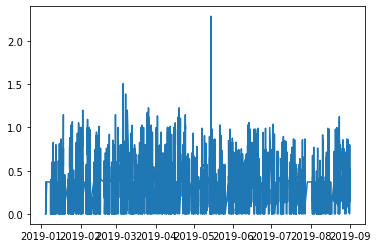

In [116]:
plt.figure()
plt.plot(curr.OccupancyDateTime, curr.PercentOccupied)
plt.show()

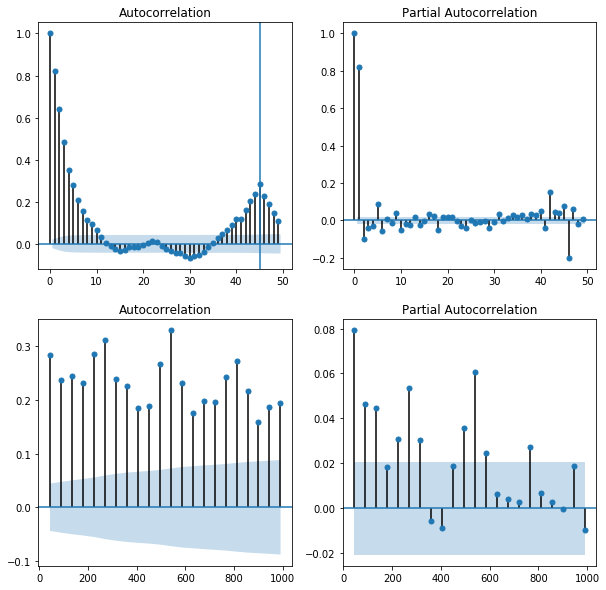

In [118]:

lags = np.arange(45, 1000, 45)

fig, axs = plt.subplots(2,2, figsize=(10,10))

(ax1, ax2, ax3, ax4) = axs.ravel()
plot_acf(pct_occupied, ax=ax1, lags=np.arange(50))
ax1.axvline(45)
plot_pacf(pct_occupied, ax=ax2, lags=np.arange(50))
plot_acf(pct_occupied, ax=ax3, lags=lags)
plot_pacf(pct_occupied, ax=ax4, lags=lags)
#ax1.axvline(36)
plt.show()

In [119]:
pct_occupied

348663    0.000000
348664    0.000000
348665    0.000000
348666    0.000000
348667    0.000000
            ...   
357744    0.142857
357745    0.219048
357746    0.285714
357747    0.523810
357748    0.295238
Name: PercentOccupied, Length: 9086, dtype: float64

In [ ]:
from pmdarima.arima import ARIMA
#for block in blockface_detail.sourceelementkey.values[:1]:
print(len(pct_occupied))


tr, tt = pct_occupied.iloc[:7500], pct_occupied.iloc[7500:]

mdl = auto_arima(tr, error_action='ignore', trace=True,
                      seasonal=True, m=45, n_jobs=-1)
preds, conf_int = mdl.predict(n_periods=tt.shape[0], return_conf_int=True)


print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(tt, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(tr.shape[0] + preds.shape[0])
x_years = x_axis + 0  # Year starts at 1821
plt.figure()
plt.plot(x_years[x_axis[:tr.shape[0]]], tr, alpha=0.75)
plt.plot(x_years[x_axis[tr.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[tr.shape[0]:]], tt,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Parking")
#plt.xlabel("Year")
plt.show()

9086


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/pmdarima/arima/auto.py:229: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 45); AIC=-10749.514, BIC=-10694.134, Fit time=297.568 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 45); AIC=-8734.292, BIC=-8720.447, Fit time=0.934 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 45); AIC=-9285.689, BIC=-9257.999, Fit time=53.200 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 45); AIC=-9136.033, BIC=-9108.343, Fit time=62.092 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 45); AIC=-9948.850, BIC=-9900.393, Fit time=261.024 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 45); AIC=-10550.239, BIC=-10487.936, Fit time=1735.473 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 45); AIC=-10085.020, BIC=-10036.562, Fit time=232.969 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 45); AIC=-10576.032, BIC=-10513.730, Fit time=1705.166 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 45); AIC=-9510.843, BIC=-9469.308, Fit time=9.665 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 45); AIC=-11035.499, BIC=-10966.274, Fit time=1846.910 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 0, 2, 45); AIC=-11126.413, BIC=-11064.110, Fit time=1696.164 seconds


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 45); AIC=-10770.097, BIC=-10714.717, Fit time=1977.132 seconds


In [35]:
def using_Grouper(df):
    level_values = df.index.get_level_values
    return (df.groupby([level_values(0)]
                       +[pd.Grouper(freq='1D', level=-1)]).sum())

In [36]:
daily_data = using_Grouper(pd.read_pickle('1.collect_data/data_files/15min.pkl').dropna())


In [37]:
daily_data.head()

PaidOccupancy  ParkingSpaceCount  \
SourceElementKey OccupancyDateTime                                     
1001             2012-01-03             65.019349         227.468172   
                 2012-01-04             54.146468         253.898471   
                 2012-01-05             66.146468         253.898471   
                 2012-01-06             75.914688         254.290896   
                 2012-01-07             64.400000         259.000000   

                                    PercentOccupied  
SourceElementKey OccupancyDateTime                   
1001             2012-01-03                9.382775  
                 2012-01-04                7.871416  
                 2012-01-05                9.585702  
                 2012-01-06               10.970685  
                 2012-01-07                9.200000

In [38]:
# shift values by one
pred_values = pd.concat([pd.Series([0]), daily_data['PaidOccupancy']])
timeseries_smape = smape_error(pred_values.values[:-1], daily_data['PaidOccupancy'])
print('smape: %f' % timeseries_smape)

smape: 19.771590
